mps


/var/folders/n7/cvn2kwps7pn1h3_vq6bbssdw0000gn/T/ipykernel_55515/2828430354.py:35: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402629672/work/build/aten/src/ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.01	Attack progress: 200 / 10000	success:144
Epsilon: 0.01	Attack progress: 400 / 10000	success:279
Epsilon: 0.01	Attack progress: 600 / 10000	success:433
Epsilon: 0.01	Attack progress: 800 / 10000	success:567
Epsilon: 0.01	Attack progress: 1000 / 10000	success:694
Epsilon: 0.01	Attack success rate: 0.6940
Epsilon: 0.02	Attack progress: 200 / 10000	success:150
Epsilon: 0.02	Attack progress: 400 / 10000	success:295
Epsilon: 0.02	Attack progress: 600 / 10000	success:436
Epsilon: 0.02	Attack progress: 800 / 10000	success:585
Epsilon: 0.02	Attack progress: 1000 / 10000	success:723
Epsilon: 0.02	Attack success rate: 0.7230
Epsilon: 0.03	Attack progress: 200 / 10000	success:146
Epsilon: 0.03	Attack progress: 400 / 10000	success:311
Epsilon: 0.03	Attack progress: 600 / 10000	success:451
Epsilon: 0.03	Attack progress: 800 / 10000	success:590
Epsilon: 0.03	Attack progress: 1000 / 10000	success:732
Epsilon: 0.03	Attack success rate: 0.7320
Epsilon: 0.1	Attack progress: 200 / 10000	succ

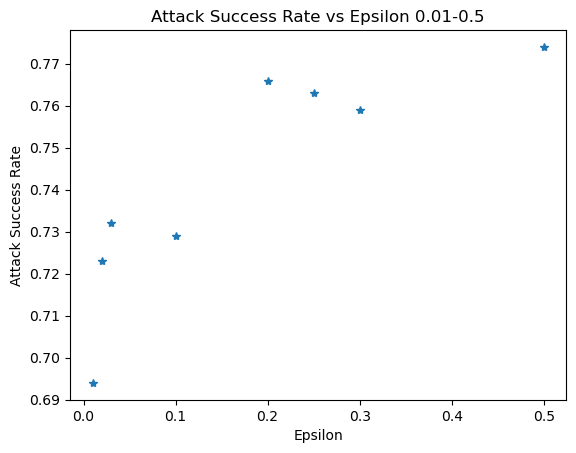

In [2]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image, -1
    perturbed_image = image
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image, -1
        if perturbed_image.grad is None:
            return False, perturbed_image, -1
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        attack_target = model(perturbed_image).max(1, keepdim=True)[1]
        if attack_target != target:
            return True, perturbed_image, attack_target
    print('attack failed, hava reached max iteration')
    return False, perturbed_image , -1

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1
        success, perturbed_data, attack_target= fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data.squeeze().detach().cpu().numpy(), perturbed_data.squeeze().detach().cpu().numpy(), target, attack_target))
        # 打印进度信息
        if correct % 200 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        if correct == 1000:
            break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [.01, .02, .03, .1, .2, .25, .3, .5]
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('./checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('./attack_data/no-dir'):
        os.makedirs('./attack_data/no-dir')    
    torch.save(ex, f'./attack_data/no-dir/eps-{eps:.3f}-ASR-{acc:.3f}.pt')


torch.save(examples, './attack_data/no-dir/attack_examples.pt')

# plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.01-0.5")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

mps


/var/folders/n7/cvn2kwps7pn1h3_vq6bbssdw0000gn/T/ipykernel_55515/762897101.py:35: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402629672/work/build/aten/src/ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.1	Attack success rate: 0.7310
Epsilon: 0.15000000000000002	Attack success rate: 0.7530
Epsilon: 0.2	Attack success rate: 0.7290
Epsilon: 0.25	Attack success rate: 0.7550
Epsilon: 0.30000000000000004	Attack success rate: 0.7790
Epsilon: 0.35	Attack success rate: 0.7690
Epsilon: 0.4	Attack success rate: 0.7850
Epsilon: 0.45000000000000007	Attack success rate: 0.7830
Epsilon: 0.5	Attack success rate: 0.7920
Epsilon: 0.55	Attack success rate: 0.7830
Epsilon: 0.6	Attack success rate: 0.8000
Epsilon: 0.65	Attack success rate: 0.8040
Epsilon: 0.7000000000000001	Attack success rate: 0.8050
Epsilon: 0.75	Attack success rate: 0.8070
Epsilon: 0.8	Attack success rate: 0.8250
Epsilon: 0.85	Attack success rate: 0.8760
Epsilon: 0.9	Attack success rate: 0.9030
Epsilon: 0.9500000000000001	Attack success rate: 0.8810
Epsilon: 1.0	Attack success rate: 0.9020


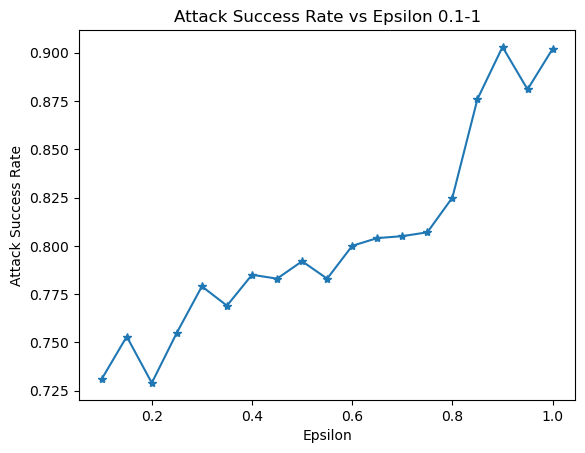

In [3]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image, -1
    perturbed_image = image
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image, -1
        if perturbed_image.grad is None:
            return False, perturbed_image, -1
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        attack_target = model(perturbed_image).max(1, keepdim=True)[1]
        if attack_target != target:
            return True, perturbed_image, attack_target
    print('attack failed, hava reached max iteration')
    return False, perturbed_image , -1

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1
        success, perturbed_data, attack_target= fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data.squeeze().detach().cpu().numpy(), perturbed_data.squeeze().detach().cpu().numpy(), target, attack_target))
        # 打印进度信息
        # if correct % 200 == 0:
        #     print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        if correct == 1000:
            break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = np.linspace(0.1, 1, 19)
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('./checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('./attack_data/no-dir'):
        os.makedirs('./attack_data/no-dir')    
    torch.save(ex, f'./attack_data/no-dir/eps-{eps:.3f}-ASR-{acc:.3f}.pt')


# torch.save(examples, './attack_data/no-dir/attack_examples.pt')

# plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.1-1")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()